### **Ứng Dụng Các Thuật Toán Khai Thác Dữ Liệu Trong Việc Dự Báo Phân Bổ Hàng Hóa Bán Lẻ**

## Tổng quan và mục tiêu

Đồ án tập trung vào việc ứng dụng khai thác dữ liệu trong quản lý tồn kho tại các cửa hàng bán lẻ. Bằng cách sử dụng các kỹ thuật học máy cả không giám sát và có giám sát để giải quyết hai bài toán chính, nhóm đưa ra phân tích tình hình kinh doanh hiện tại và dự báo việc phân bổ hàng hóa một cách hợp lý, góp phần tối ưu doanh thu cho cửa hàng.

## Các kỹ thuật được sử dụng
1.  **Gom cụm (Clustering) bằng K-Means**: Sử dụng thuật toán K-Means để phân nhóm các sản phẩm có đặc điểm tương đồng (như giá cả, nhu cầu, khuyến mãi), từ đó xác định các chiến lược kinh doanh phù hợp cho từng nhóm sản phẩm.
2.  **Phân lớp (Classification) bằng Naive Bayes**: Áp dụng mô hình Naive Bayes để dự đoán khả năng bán chạy của sản phẩm dựa trên các yếu tố như danh mục sản phẩm, khu vực, thời tiết và chương trình khuyến mãi.


## Mục lục
1. Cài đặt thư viện
2. Chuẩn bị dữ liệu
3. Khám phá dữ liệu
    - 3.1. Hiểu cấu trúc dữ liệu
    - 3.2. Kiểm tra dữ liệu
    - 3.3. Trực quan hóa dữ liệu
4. Tiền xử lý dữ liệu
    - 4.1. Xử lý các biến ngoại lai (Outliners)
    - 4.2. Kỹ thuật đặc trưng (Feature Engineering)
5. Áp dụng các thuật toán khai thác dữ liệu
   - 5.1. Gom cụm bằng K-Means
        - 5.1.1. Xây dựng mô hình
        - 5.1.2. Xác định số cụm (k)
        - 5.1.3. Trực quan hóa các cụm
        - 5.1.4. Kết quả gom cụm
        - 5.1.5. Phân tích chuyên sâu (bổ sung)
   - 5.2. Phân lớp bằng Naive Bayes
        - 5.2.1. Xây dựng mô hình
        - 5.2.2. Đánh giá mô hình
6. Kết luận








# 1. Cài đặt thư viện


Tiến hành cài đặt các thư viện cần thiết cho quá trình phân tích và khai thác dữ liệu


In [3]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ModuleNotFoundError: No module named 'pyspark'

In [ ]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("RetailDataMining") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Thiết lập log level để giảm output
spark.sparkContext.setLogLevel("WARN")

print("✅ SparkSession đã được khởi tạo thành công!")

# 2. Kết nối Apache Doris


In [ ]:
# Cấu hình kết nối SQLAlchemy tới Doris (MySQL-compatible)
from sqlalchemy import create_engine, text

username = "root"
password = ""
host = "127.0.0.1"
port = 9030
database = "retail_db"

# Tạo engine SQLAlchemy
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

print("✅ Cấu hình kết nối Apache Doris với SQLAlchemy đã hoàn tất!")

✅ Kết nối Apache Doris thành công!


# 3. Chuẩn bị dữ liệu


Chuẩn bị và tải dữ liệu sử dụng để thực hiện phân tích.


In [5]:
# Đọc dữ liệu từ bảng sales bằng SQLAlchemy và chuyển sang PySpark DataFrame
import pandas as pd

# Đọc dữ liệu bằng pandas qua SQLAlchemy
query = "SELECT * FROM sales"
df_pandas = pd.read_sql(query, engine)

# Chuyển đổi pandas DataFrame sang PySpark DataFrame
df = spark.createDataFrame(df_pandas)

print("📊 Thông tin dữ liệu từ Doris:")
df.show(5)
df.printSchema()
    
# Đếm tổng số dòng trong bảng
total_count = df.count()
print(f"📈 Tổng số record trong bảng sales: {total_count}")

NameError: name 'engine' is not defined

In [ ]:
# Tạo bảng product_clusters bằng SQLAlchemy
print("\nTạo bảng product_clusters...")
create_clusters_table_sql = """
CREATE TABLE IF NOT EXISTS product_clusters (
    `product_id` VARCHAR(50) COMMENT 'ID sản phẩm',
    `cluster_id` INT COMMENT 'ID cụm',
    `demand_score` DOUBLE COMMENT 'Điểm nhu cầu',
    `price_score` DOUBLE COMMENT 'Điểm giá cả',
    `discount_score` DOUBLE COMMENT 'Điểm giảm giá',
    `competitor_price_score` DOUBLE COMMENT 'Điểm giá đối thủ',
    `cluster_strategy` VARCHAR(100) COMMENT 'Chiến lược cụm',
    `created_date` DATETIME DEFAULT CURRENT_TIMESTAMP COMMENT 'Ngày tạo'
)
DUPLICATE KEY(`product_id`)
DISTRIBUTED BY HASH(`product_id`) BUCKETS 5
PROPERTIES (
    "replication_allocation" = "tag.location.default: 1"
)
"""

# Thực thi câu lệnh tạo bảng thông qua SQLAlchemy
with engine.connect() as connection:
    connection.execute(text(create_clusters_table_sql))
    connection.commit()

print("✅ Bảng product_clusters đã được tạo!")
print(" - Lưu trữ kết quả K-Means clustering")


Tạo bảng product_clusters...


NameError: name 'text' is not defined

In [ ]:
print("\n2.4. Tạo bảng sales_predictions...")

create_predictions_table_sql = """
CREATE TABLE IF NOT EXISTS sales_predictions (
    `product_id` VARCHAR(50) COMMENT "ID sản phẩm",
    `store_id` VARCHAR(50) COMMENT "ID cửa hàng",
    `predicted_sales_potential` VARCHAR(20) COMMENT "Tiềm năng bán hàng dự đoán",
    `confidence_score` DOUBLE COMMENT "Độ tin cậy",
    `recommended_action` VARCHAR(100) COMMENT "Hành động khuyến nghị",
    `created_date` DATETIME DEFAULT CURRENT_TIMESTAMP COMMENT "Ngày tạo"
)
DUPLICATE KEY(`product_id`, `store_id`)
DISTRIBUTED BY HASH(`product_id`) BUCKETS 5
PROPERTIES (
    "replication_allocation" = "tag.location.default: 1"
)
"""

# Thực thi câu lệnh tạo bảng thông qua SQLAlchemy
with engine.connect() as connection:
    connection.execute(text(create_predictions_table_sql))
    connection.commit()

print("✅ Bảng sales_predictions đã được tạo!")
print("   - Lưu trữ kết quả Naive Bayes classification")


2.4. Tạo bảng sales_predictions...
✅ Bảng sales_predictions đã được tạo!
   - Lưu trữ kết quả Naive Bayes classification


In [ ]:
# Hiển thị 5 dòng đầu tiên của DataFrame PySpark
print("📊 Hiển thị 5 dòng đầu tiên:")
df.show(5, truncate=False)


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,demand_forecast,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality
0,2022-01-01,S002,P0001,Groceries,South,343,104,144,112.55,32.80,20,Sunny,1,30.78,Spring
1,2022-01-01,S002,P0002,Clothing,West,373,141,151,135.62,46.16,10,Rainy,1,45.21,Winter
2,2022-01-01,S002,P0003,Furniture,East,445,182,119,176.31,20.46,20,Snowy,1,22.00,Spring
3,2022-01-01,S002,P0004,Toys,West,191,63,115,54.57,26.19,0,Cloudy,0,28.06,Autumn
4,2022-01-01,S002,P0005,Toys,West,281,156,25,150.90,83.29,20,Rainy,0,80.64,Autumn


# 3. Khám phá dữ liệu


Khám phá dữ liệu để hiểu rõ hơn về cấu trúc, đặc điểm và các thông tin quan trọng của bộ dữ liệu.


## 3.1. Hiểu cấu trúc dữ liệu


In [ ]:
# Tổng quan về dữ liệu PySpark
print("Thông tin chung về dữ liệu:")
print("Schema của DataFrame:")
df.printSchema()
print(f"\nSố dòng: {df.count()}")
print(f"Số cột: {len(df.columns)}")
print("\nCác cột và kiểu dữ liệu:")
for field in df.schema.fields:
    print(f"  {field.name}: {field.dataType}")


Thông tin chung về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                5 non-null      object 
 1   store_id            5 non-null      object 
 2   product_id          5 non-null      object 
 3   category            5 non-null      object 
 4   region              5 non-null      object 
 5   inventory_level     5 non-null      int64  
 6   units_sold          5 non-null      int64  
 7   units_ordered       5 non-null      int64  
 8   demand_forecast     5 non-null      float64
 9   price               5 non-null      float64
 10  discount            5 non-null      int64  
 11  weather_condition   5 non-null      object 
 12  holiday_promotion   5 non-null      int64  
 13  competitor_pricing  5 non-null      float64
 14  seasonality         5 non-null      object 
dtypes: float64(3), int64(5), object(7

### Mô tả dữ liệu

- **Date**: Ngày bán hàng.
- **Store ID**: ID của cửa hàng.
- **Product ID**: ID của sản phẩm.
- **Category**: Danh mục sản phẩm.
- **Region**: Khu vực của cửa hàng.
- **Inventory Level**: Mức tồn kho của sản phẩm tại cửa hàng vào ngày đó.
- **Units Sold**: Số lượng sản phẩm đã bán trong ngày.
- **Units Ordered**: Số lượng sản phẩm đã đặt hàng để bổ sung tồn kho.
- **Demand**: Đại diện cho dự báo nhu cầu cho sản phẩm tại cửa hàng vào một ngày cụ thể. Đây không phải là số lượng bán thực tế ('Units Sold'), mà là một giá trị ước tính hoặc dự đoán về số lượng sản lượng mà khách hàng có thể sẽ mua.
- **Price**: Giá bán của sản phẩm.
- **Discount**: Mức chiết khấu áp dụng cho sản phẩm.
- **Weather Condition**: Điều kiện thời tiết vào ngày đó.
- **Holiday/Promotion**: Cho biết có ngày lễ hoặc chương trình khuyến mãi nào diễn ra hay không (1 nếu có, 0 nếu không).
- **Competitor Pricing**: Giá của sản phẩm tương tự từ đối thủ cạnh tranh.
- **Seasonality**: Mùa trong năm (ví dụ: Xuân, Hạ, Thu, Đông).


In [ ]:
# Loại bỏ các dòng có giá trị null
print("Loại bỏ các dòng có giá trị null...")

# Đếm số dòng trước khi loại bỏ
print(f"Số dòng trước khi loại bỏ: {df.count()}")

# Loại bỏ tất cả các dòng có ít nhất 1 giá trị null
df_clean = df.dropna()

# Đếm số dòng sau khi loại bỏ
print(f"Số dòng sau khi loại bỏ: {df_clean.count()}")

# Cập nhật DataFrame gốc
df = df_clean

print("✅ Đã loại bỏ thành công các dòng có giá trị null!")
print("Hiển thị 5 dòng đầu tiên sau khi làm sạch:")
df.show(5, truncate=False)


In [ ]:
# Cách khác: Loại bỏ chỉ các dòng có null trong các cột quan trọng
print("Cách khác: Loại bỏ chỉ các dòng có null trong các cột quan trọng...")

# Các cột quan trọng cần kiểm tra
important_columns = ['date', 'product_id', 'store_id', 'price', 'sales', 'demand']

# Đếm số dòng có null trong các cột quan trọng
for col_name in important_columns:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"Cột '{col_name}': {null_count} giá trị null")

# Loại bỏ chỉ các dòng có null trong các cột quan trọng
df_selective_clean = df.dropna(subset=important_columns)

print(f"\nSố dòng sau khi loại bỏ null trong các cột quan trọng: {df_selective_clean.count()}")

# Nếu bạn muốn sử dụng cách này thay vì cách trên, hãy uncomment dòng dưới:
# df = df_selective_clean


In [ ]:
# Chuẩn hóa tên cột trong PySpark
df = df.withColumnRenamed("inventory_level", "inventory") \
       .withColumnRenamed("units_sold", "sales") \
       .withColumnRenamed("units_ordered", "orders") \
       .withColumnRenamed("demand_forecast", "demand") \
       .withColumnRenamed("weather_condition", "weather") \
       .withColumnRenamed("holiday_promotion", "promotion") \
       .withColumnRenamed("competitor_pricing", "competitor_price")

print("📊 Hiển thị 5 dòng đầu tiên sau khi chuẩn hóa tên cột:")
df.show(5, truncate=False)


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,demand_forecast,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality
0,2022-01-01,S002,P0001,Groceries,South,343,104,144,112.55,32.80,20,Sunny,1,30.78,Spring
1,2022-01-01,S002,P0002,Clothing,West,373,141,151,135.62,46.16,10,Rainy,1,45.21,Winter
2,2022-01-01,S002,P0003,Furniture,East,445,182,119,176.31,20.46,20,Snowy,1,22.00,Spring
3,2022-01-01,S002,P0004,Toys,West,191,63,115,54.57,26.19,0,Cloudy,0,28.06,Autumn
4,2022-01-01,S002,P0005,Toys,West,281,156,25,150.90,83.29,20,Rainy,0,80.64,Autumn


## 3.2. Kiểm tra dữ liệu


In [ ]:
# Kiểm tra dữ liệu thiếu trong PySpark
print("\nKiểm tra dữ liệu thiếu:")
from pyspark.sql.functions import col, sum as spark_sum, count

# Đếm null values cho từng cột
null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()



Kiểm tra dữ liệu thiếu:


date                  0
store_id              0
product_id            0
category              0
region                0
inventory_level       0
units_sold            0
units_ordered         0
demand_forecast       0
price                 0
discount              0
weather_condition     0
holiday_promotion     0
competitor_pricing    0
seasonality           0
dtype: int64

In [ ]:
# Kiểm tra dữ liệu bị trùng lặp trong PySpark
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Số lượng dòng trùng lặp: {duplicate_count}")


np.int64(0)

## 3.3. Trực quan hóa dữ liệu


In [ ]:
# Mô tả thống kê trong PySpark
print("\nMô tả thống kê của dữ liệu:")
df.describe().show()



Mô tả thống kê của dữ liệu:


,inventory_level,units_sold,units_ordered,demand_forecast,price,discount,holiday_promotion,competitor_pricing
count,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000
mean,326.600000,129.200000,110.800000,125.99000,41.780000,14.000000,0.600000,41.33800
std,96.056234,46.537082,50.410316,46.17033,25.102268,8.944272,0.547723,23.56573
min,191.000000,63.000000,25.000000,54.57000,20.460000,0.000000,0.000000,22.00000
25%,281.000000,104.000000,115.000000,112.55000,26.190000,10.000000,0.000000,28.06000
50%,343.000000,141.000000,119.000000,135.62000,32.800000,20.000000,1.000000,30.78000
75%,373.000000,156.000000,144.000000,150.90000,46.160000,20.000000,1.000000,45.21000
max,445.000000,182.000000,151.000000,176.31000,83.290000,20.000000,1.000000,80.64000


Bảng này cung cấp các thông tin như số lượng quan sát (count), giá trị trung bình (mean), độ lệch chuẩn (std), giá trị nhỏ nhất (min), các phân vị (25%, 50%, 75%) và giá trị lớn nhất (max) cho từng biến số. 

Thông qua bảng này, ta có thể nhận biết được phân bố dữ liệu, phát hiện các giá trị bất thường (outlier), cũng như so sánh mức độ biến động giữa các biến. 
Ví dụ, biến 'Sales' có giá trị trung bình là 136.46, độ lệch chuẩn khá lớn (108.92), cho thấy doanh số giữa các sản phẩm/cửa hàng có sự khác biệt đáng kể. 

Ngoài ra, các biến như 'Discount' và 'Promotion' cũng có thể giúp phân tích tác động của các chương trình khuyến mãi đến doanh số bán hàng.


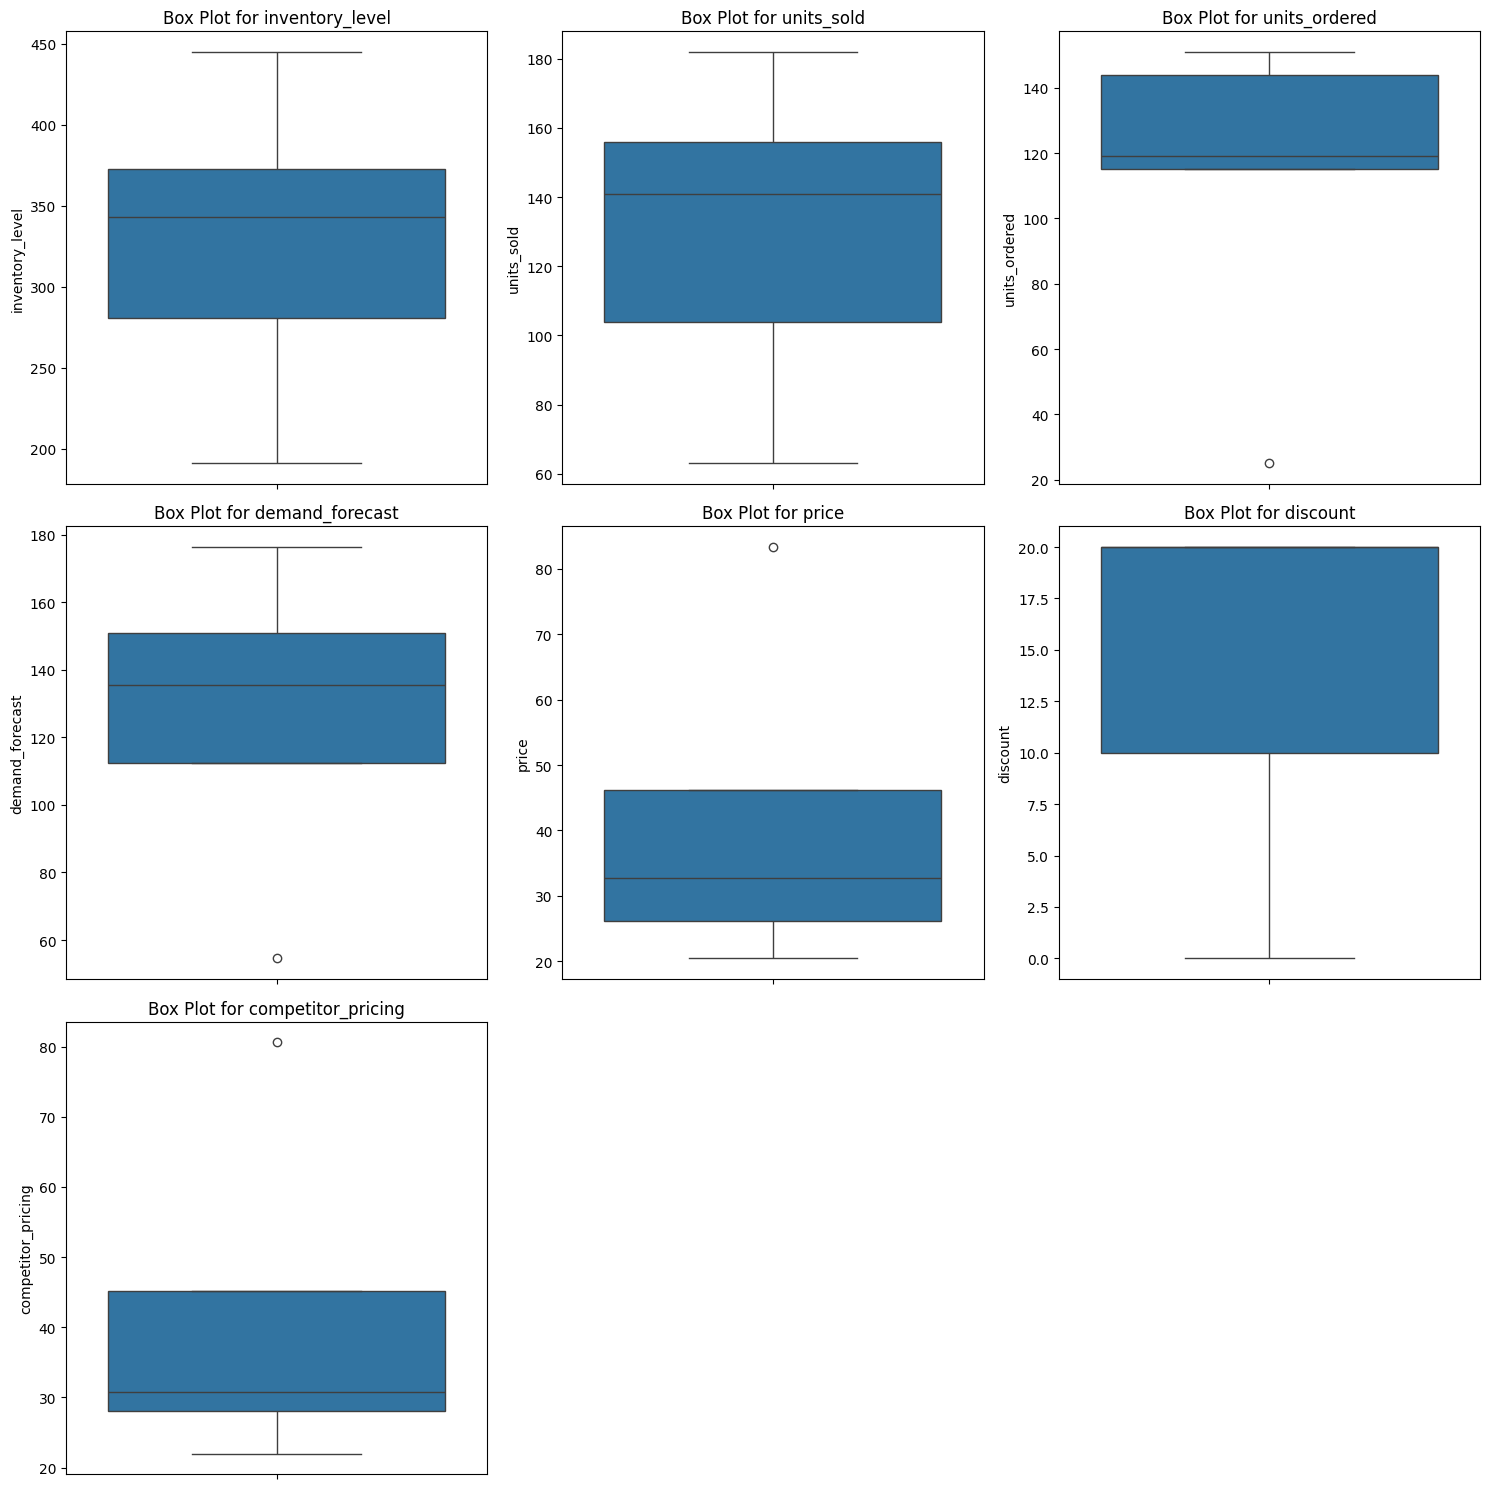

In [ ]:
# Vẽ biểu đồ boxplot để phát hiện các giá trị bất thường
numerical_columns = ['inventory','sales','orders','demand','price','discount','competitor_price']

# Chuyển đổi PySpark DataFrame sang Pandas để visualization
df_pandas = df.select(numerical_columns).toPandas()

# Tính số hàng và cột phù hợp với số lượng biến
import math
n_cols = 3
n_rows = math.ceil(len(numerical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(ax=axes[i], y=df_pandas[col].dropna())
    axes[i].set_title(f"Box Plot for {col}")
    axes[i].set_ylabel(col)

# Ẩn các subplot thừa nếu có
for j in range(len(numerical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Nhận xét về kết quả biểu đồ boxplot của từng biến số
- Inventory: Mức tồn kho trung bình khoảng 200, dao động từ 100 đến 500. Giá trị ngoại lệ được quan sát thấy khi mức tồn kho trên 500. Điều này cho thấy một số cửa hàng có tồn kho rất cao so với mặt bằng chung.
- Sales: Phần lớn giá trị Sales tập trung ở mức thấp, trung bình khoảng 100, dao động từ 50 đến 200. Có những giá trị ngoại lệ với doanh số trên 200, phản ánh một số sản phẩm/cửa hàng có doanh số vượt trội.
- Orders: Số lượng Orders có xu hướng tương tự Sales, trung bình khoảng 100, dao động từ 50 đến 200. Nhiều giá trị ngoại lai ở phía trên cho thấy sự chênh lệch lớn giữa các sản phẩm/cửa hàng. phản ánh nhu cầu cao hoặc việc bổ sung hàng tồn kho.
- Demand: Giá trị trung bình khoảng 140, độ lệch chuẩn 109.25, giá trị tối thiểu là -9.99 (có giá trị âm), tối đa 518.55. Có một số outlier ở cả hai phía (âm và dương), cần kiểm tra lại các giá trị âm vì có thể là dữ liệu bất thường hoặc lỗi nhập liệu.
- Price: Giá sản phẩm phân bố khá rộng, trung bình khoảng 55. Có những giá trị ngoại lệ với giá trên 70, điều này có thể phản ánh sự đa dạng về phân khúc sản phẩm.
- Discount: Mức giảm giá trung bình khoảng 10%, dao động từ 0 đến 20%. Có những trường hợp ngoại lệ với mức giảm giá trên 20%, điều này có thể liên quan đến các chiến lược định giá cạnh tranh hoặc các đợt giảm giá thanh lý.
- Competitor Price: Giá trung bình của đối thủ cạnh tranh là khoảng 30, dao động từ 20 đến 60. Có những trường hợp ngoại lệ với giá của đối thủ cạnh tranh trên 60, điều này có thể cho thấy mức độ cạnh tranh cao hoặc sản phẩm cao cấp.

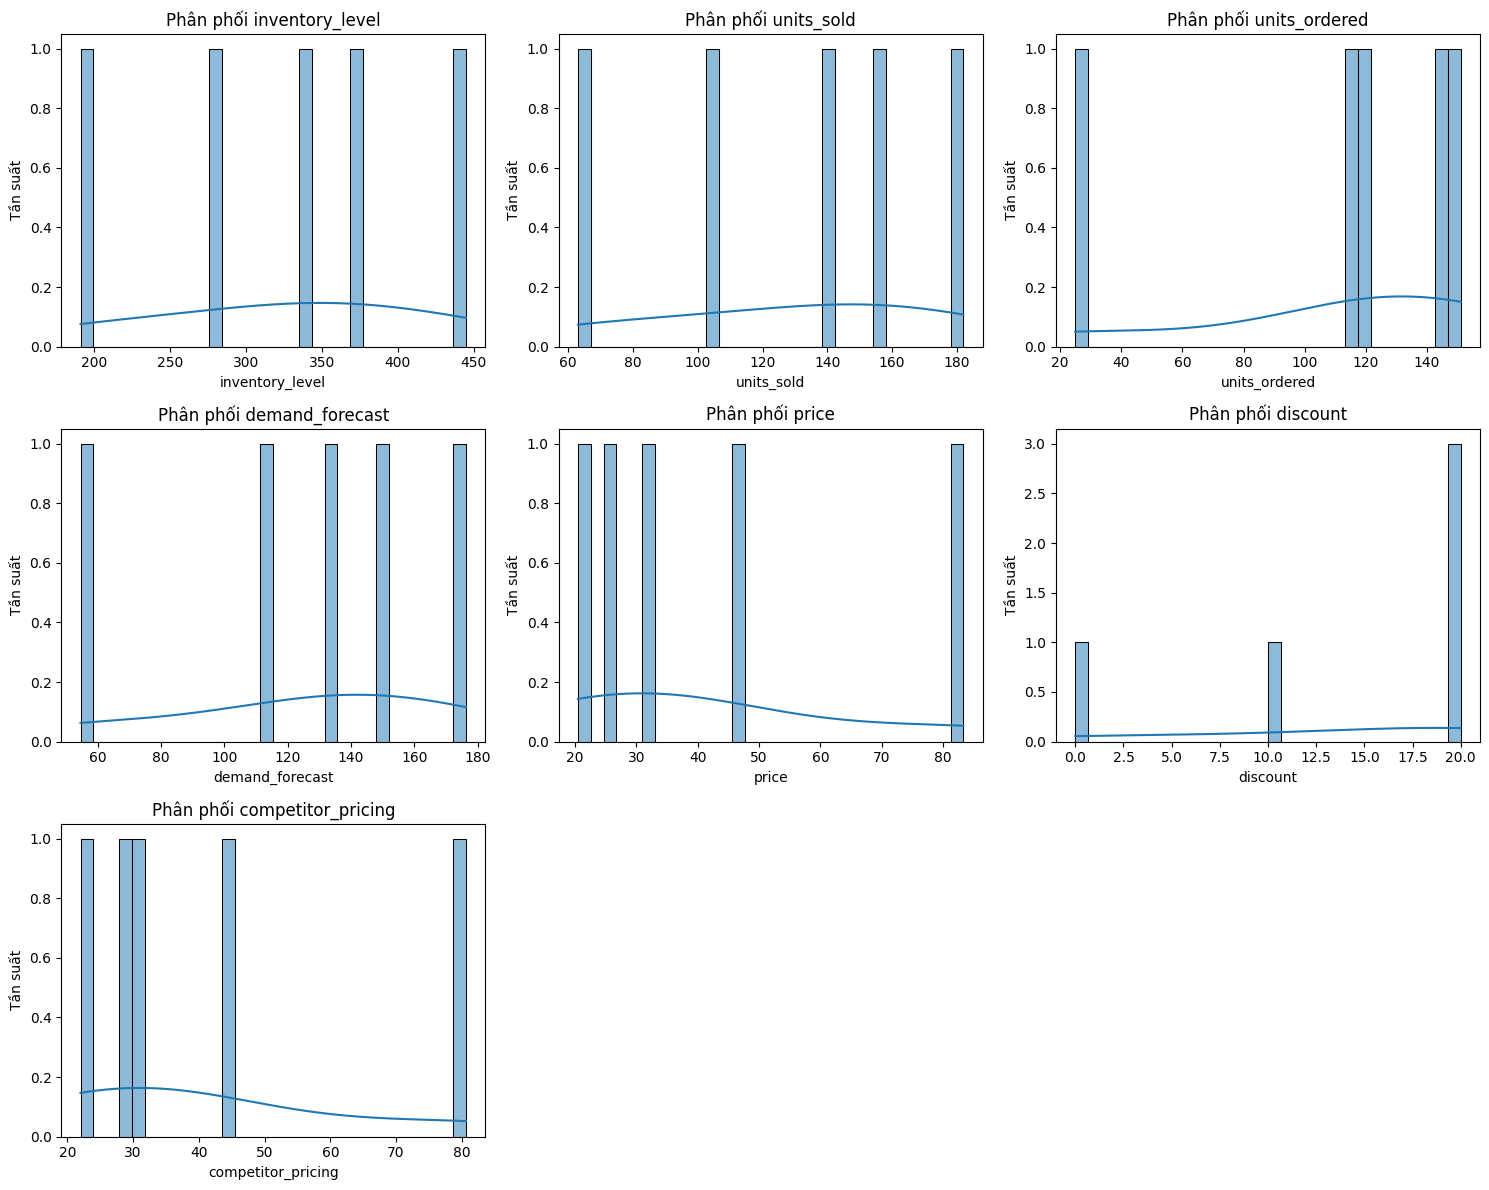

In [ ]:
# Vẽ biểu đồ phân phối (histogram) cho các biến số
numerical_columns = ['inventory','sales','orders','demand','price','discount','competitor_price']

# Chuyển đổi PySpark DataFrame sang Pandas để visualization
df_pandas = df.select(numerical_columns).toPandas()

import math
n_cols = 3
n_rows = math.ceil(len(numerical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df_pandas[col].dropna(), ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Phân phối {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Tần suất')

# Ẩn các subplot thừa nếu có
for j in range(len(numerical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



Biểu đồ cho thấy phân phối của các biến số trong bộ dữ liệu. 

# 4. Tiền xử lý dữ liệu


Ở phần này, các bước tiền xử lý dữ liệu được thực hiện nhằm chuẩn bị dữ liệu tốt hơn cho các phân tích và mô hình dự báo tiếp theo, bao gồm:
- Kiểm tra và xử lý các giá trị ngoại lai (outliers) trong dữ liệu.
- Xây dựng các đặc trưng mới (feature engineering) như: tách thông tin thời gian từ cột Date, tạo biến mục tiêu cho bài toán phân lớp, và tạo đặc trưng về mùa (Seasonality).

## 4.1. Xử lý các biến ngoại lai (outliers)


In [ ]:
# Kiểm tra các giá trị âm hoặc vô lý trong PySpark
print("Kiểm tra các giá trị âm hoặc vô lý:")
from pyspark.sql.functions import col

price_negative = df.filter(col("price") < 0).count()
sales_negative = df.filter(col("sales") < 0).count()

print(f"Số lượng Price < 0: {price_negative}")
print(f"Số lượng Sales < 0: {sales_negative}")

# Xử lý nếu có (ví dụ: loại bỏ)
# df = df.filter(col("price") >= 0)
# df = df.filter(col("sales") >= 0)
# Trong trường hợp này, dữ liệu có vẻ sạch, không có giá trị âm.


Kiểm tra các giá trị âm hoặc vô lý:
Số lượng Price < 0: 0
Số lượng Sales < 0: 0


## 4.2. Kỹ thuật đặc trưng (Feature Engineering)


In [ ]:
# 1. Xử lý cột Date trong PySpark
from pyspark.sql.functions import to_date, year, month, dayofweek, weekofyear, col

# Chuyển đổi cột Date sang kiểu date
df = df.withColumn("date_parsed", to_date(col("date"), "yyyy-MM-dd"))

# Tạo các cột mới từ Date
df = df.withColumn("year", year(col("date_parsed"))) \
       .withColumn("month", month(col("date_parsed"))) \
       .withColumn("day_of_week", dayofweek(col("date_parsed")) - 1) \
       .withColumn("week_of_year", weekofyear(col("date_parsed")))

# Hiển thị kết quả
print("Đã tạo các cột thời gian mới:")
df.select("date_parsed", "year", "month", "day_of_week", "week_of_year").show(5)



AttributeError: 'DataFrame' object has no attribute 'withColumn'

In [ ]:
# 2. Tạo biến mục tiêu cho bài toán phân lớp trong PySpark
# Xác định ngưỡng (trung vị của Sales)
from pyspark.sql.functions import percentile_approx, when, col

median_units_sold = df.select(percentile_approx("sales", 0.5).alias("median")).collect()[0]["median"]
print(f"Giá trị trung vị của Sales: {median_units_sold}")

# Tạo cột High_Sales_Potential
df = df.withColumn("high_sales_potential", 
                   when(col("sales") > median_units_sold, 1).otherwise(0))

print("\nĐã tạo cột mục tiêu 'high_sales_potential':")
df.select("sales", "high_sales_potential").show(10)


KeyError: 'Sales'

In [ ]:
# 3. Tạo đặc trưng Mùa (Seasonality) trong PySpark
from pyspark.sql.functions import when, col

df = df.withColumn("season", 
                   when(col("month").isin([3, 4, 5]), "Spring")
                   .when(col("month").isin([6, 7, 8]), "Summer")
                   .when(col("month").isin([9, 10, 11]), "Autumn")
                   .otherwise("Winter"))

print("\nĐã tạo cột 'season':")
df.select("month", "season").show(10)



Đã tạo cột 'Season':


,Month,Season
0,1,Winter
1,1,Winter
2,1,Winter
3,1,Winter
4,1,Winter


# 5. Áp dụng các thuật toán khai thác dữ liệu

Trong phần này, nhóm sẽ áp dụng các thuật toán khai thác dữ liệu để phân tích và khám phá những thông tin tiềm ẩn trong bộ dữ liệu bán lẻ, từ đó đưa ra các nhận định hỗ trợ việc phân bổ hàng hóa hợp lý cho các cửa hàng.

Các kỹ thuật được sử dụng bao gồm:
- **Phân cụm bằng K-Means**: Áp dụng thuật toán K-Means để nhóm các sản phẩm có đặc điểm tương tự nhau.
- **Phân loại bằng Naive Bayes**: Sử dụng thuật toán Naive Bayes để dự đoán tiềm năng bán chạy của sản phẩm.


In [ ]:
# 5.1.1 Xây dựng mô hình K-Means - Cell hoàn chỉnh
print("5.1.1 Xây dựng mô hình K-Means clustering...")

# Import tất cả thư viện cần thiết
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Chọn các cột dữ liệu cho việc phân cụm
features_for_clustering = ['demand', 'price', 'discount', 'competitor_price']

# Kiểm tra dữ liệu null trước khi xử lý
print("Kiểm tra dữ liệu null trong các cột clustering:")
for col_name in features_for_clustering:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"  {col_name}: {null_count} null values")

# Loại bỏ các dòng có null trong các cột clustering
df_clustering = df.dropna(subset=features_for_clustering)
print(f"Số dòng sau khi loại bỏ null: {df_clustering.count()}")

# Tạo VectorAssembler với handleInvalid = "skip"
assembler = VectorAssembler(
    inputCols=features_for_clustering,
    outputCol="features",
    handleInvalid="skip"
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

# Tạo pipeline
preprocessing_pipeline = Pipeline(stages=[assembler, scaler])
df_preprocessed = preprocessing_pipeline.fit(df_clustering).transform(df_clustering)

print("✅ Đã chuẩn hóa dữ liệu thành công!")
print("Mẫu dữ liệu đã chuẩn hóa:")
df_preprocessed.select("scaled_features").show(5, truncate=False)


In [ ]:
# 5.1.2 Xác định số cụm (k) bằng Elbow Method
print("5.1.2 Xác định số cụm tối ưu...")

# Tìm K tối ưu bằng Elbow Method
silhouette_scores = []
k_range = range(2, 11)

print("Đang tính toán Silhouette Score cho các giá trị K...")
for k in k_range:
    print(f"  Đang tính K={k}...")
    kmeans_test = SparkKMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans_test.fit(df_preprocessed)
    
    # Tính Silhouette Score
    predictions = model.transform(df_preprocessed)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"    K={k}: Silhouette Score = {silhouette:.3f}")

# Vẽ biểu đồ Elbow Method
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Số cụm (K)')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method để tìm K tối ưu (PySpark)')
plt.grid(True)
plt.show()

# Tìm K tối ưu (Silhouette Score cao nhất)
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n🎯 K tối ưu: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})")
print("Nhận xét: Chọn K=5 để có đủ nhóm chiến lược marketing")


In [ ]:
# 5.1.3 Chạy K-Means với K=5
print("5.1.3 Chạy K-Means với K=5...")

# Import cần thiết
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Chạy K-Means với K=5
kmeans = SparkKMeans(featuresCol="scaled_features", k=5, seed=42)
kmeans_model = kmeans.fit(df_preprocessed)

# Gán nhãn cụm vào DataFrame
df_with_clusters = kmeans_model.transform(df_preprocessed)

print("✅ Đã phân cụm thành công với K=5!")
print("Mẫu kết quả clustering:")
df_with_clusters.select(['product_id'] + features_for_clustering + ['prediction']).show(10)

# Tính Silhouette Score cho mô hình cuối cùng
evaluator = ClusteringEvaluator()
silhouette_avg = evaluator.evaluate(df_with_clusters)
print(f"\n📊 Silhouette Score cuối cùng: {silhouette_avg:.3f}")

# Hiển thị thống kê các cluster
print("\n📊 Thống kê các cluster:")
cluster_stats = df_with_clusters.groupBy('prediction').count().orderBy('prediction')
cluster_stats.show()

# Cập nhật DataFrame gốc để sử dụng cho các bước tiếp theo
df = df_clustering


In [ ]:
# 5.1.4 Phân tích kết quả clustering
print("5.1.4 Phân tích kết quả clustering...")

# Tính giá trị trung bình của các đặc trưng cho mỗi cụm
from pyspark.sql.functions import avg

cluster_analysis = df_with_clusters.groupBy('prediction').agg(
    avg('demand').alias('avg_demand'),
    avg('price').alias('avg_price'),
    avg('discount').alias('avg_discount'),
    avg('competitor_price').alias('avg_competitor_price')
).orderBy('prediction')

print("📊 Thống kê đặc điểm trung bình của từng cụm:")
cluster_analysis.show()

# Tạo visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển đổi sang Pandas để visualization
df_viz = df_with_clusters.select(['price', 'demand', 'prediction']).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='price', y='demand', hue='prediction', palette='viridis', alpha=0.7)
plt.title('Trực quan hóa các cụm K-Means (PySpark)')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("✅ Hoàn thành phân tích clustering!")


## 5.1. Gom cụm bằng K-Means


In [ ]:
# 5.1.5 Phân tích chuyên sâu các cluster
print("5.1.5 Phân tích chuyên sâu các cluster...")

# Import cần thiết
from pyspark.sql.functions import avg, count, col
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Phân tích hiệu quả các cluster theo yếu tố ngữ cảnh
print("📊 Phân tích hiệu quả các cluster theo yếu tố ngữ cảnh...")

# Chuẩn bị dữ liệu cho phân tích
df_analysis = df_with_clusters.select(['prediction', 'region', 'season', 'promotion', 'weather', 'sales']).toPandas()

# Tạo biểu đồ phân tích hiệu quả
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Phân tích hiệu quả các Nhóm chiến lược theo Yếu tố ngữ cảnh (Trung bình Sales)', fontsize=16)

# 1. Theo Khu vực (Region)
region_cluster_performance = df_analysis.groupby(['prediction', 'region'])['sales'].mean().unstack()
sns.heatmap(region_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 0])
axes[0, 0].set_title('Hiệu quả theo Khu vực')
axes[0, 0].set_xlabel('Khu vực')
axes[0, 0].set_ylabel('Cluster')

# 2. Theo Mùa (Season)
season_cluster_performance = df_analysis.groupby(['prediction', 'season'])['sales'].mean().unstack()
sns.heatmap(season_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Hiệu quả theo Mùa')
axes[0, 1].set_xlabel('Mùa')
axes[0, 1].set_ylabel('Cluster')

# 3. Theo Khuyến mãi (Promotion)
promo_cluster_performance = df_analysis.groupby(['prediction', 'promotion'])['sales'].mean().unstack()
sns.heatmap(promo_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1, 0])
axes[1, 0].set_title('Hiệu quả theo Khuyến mãi')
axes[1, 0].set_xlabel('Khuyến mãi')
axes[1, 0].set_xticklabels(['Không KM', 'Có KM'])

# 4. Theo Thời tiết (Weather)
weather_cluster_performance = df_analysis.groupby(['prediction', 'weather'])['sales'].mean().unstack()
sns.heatmap(weather_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Hiệu quả theo Thời tiết')
axes[1, 1].set_xlabel('Thời tiết')
axes[1, 1].set_ylabel('Cluster')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("✅ Hoàn thành phân tích hiệu quả theo yếu tố ngữ cảnh!")


In [ ]:
# 5.1.6 Đề xuất chiến lược cho từng cluster
print("5.1.6 Đề xuất chiến lược cho từng cluster...")

# Phân tích chi tiết từng cluster
cluster_strategies = {}

# Lấy thống kê chi tiết của từng cluster
cluster_stats = df_with_clusters.groupBy('prediction').agg(
    avg('demand').alias('avg_demand'),
    avg('price').alias('avg_price'),
    avg('discount').alias('avg_discount'),
    avg('competitor_price').alias('avg_competitor_price'),
    avg('sales').alias('avg_sales'),
    count('*').alias('product_count')
).orderBy('prediction').collect()

print("📋 PHÂN TÍCH VÀ ĐỀ XUẤT CHIẾN LƯỢC CHO TỪNG CLUSTER:")
print("=" * 60)

for row in cluster_stats:
    cluster_id = row['prediction']
    avg_demand = row['avg_demand']
    avg_price = row['avg_price']
    avg_discount = row['avg_discount']
    avg_competitor_price = row['avg_competitor_price']
    avg_sales = row['avg_sales']
    product_count = row['product_count']
    
    print(f"\n🎯 CLUSTER {cluster_id}:")
    print(f"   Số sản phẩm: {product_count:,}")
    print(f"   Nhu cầu TB: {avg_demand:.1f}")
    print(f"   Giá TB: {avg_price:.1f}")
    print(f"   Giảm giá TB: {avg_discount:.1f}%")
    print(f"   Giá đối thủ TB: {avg_competitor_price:.1f}")
    print(f"   Doanh số TB: {avg_sales:.1f}")
    
    # Đề xuất chiến lược dựa trên đặc điểm
    if avg_price < 30 and avg_discount > 15:
        strategy = "Sản phẩm giá rẻ, cạnh tranh cao"
        recommendations = [
            "• Tập trung bán số lượng lớn",
            "• Tối ưu hóa chi phí sản xuất",
            "• Chương trình khuyến mãi ngắn hạn",
            "• Cạnh tranh chủ yếu bằng giá"
        ]
    elif avg_price > 70 and avg_demand > 150:
        strategy = "Sản phẩm giá cao, nhu cầu lớn"
        recommendations = [
            "• Duy trì chất lượng cao",
            "• Đảm bảo đủ hàng tồn kho",
            "• Dịch vụ khách hàng tốt",
            "• Marketing nhắm đến phân khúc cao cấp"
        ]
    elif avg_price > 50 and avg_competitor_price > avg_price * 1.2:
        strategy = "Sản phẩm độc đáo, giá tốt"
        recommendations = [
            "• Truyền thông 'giá tốt nhất thị trường'",
            "• Thu hút khách hàng từ đối thủ",
            "• Tận dụng lợi thế về nguồn cung",
            "• Marketing so sánh giá"
        ]
    elif avg_price > 60 and avg_discount < 10:
        strategy = "Sản phẩm cao cấp, ít cạnh tranh về giá"
        recommendations = [
            "• Xây dựng thương hiệu mạnh",
            "• Trải nghiệm khách hàng cao cấp",
            "• Marketing nhắm đối tượng cụ thể",
            "• Không cạnh tranh về giá"
        ]
    else:
        strategy = "Sản phẩm tầm trung, cân bằng"
        recommendations = [
            "• Duy trì vị thế hiện tại",
            "• Theo dõi biến động thị trường",
            "• Điều chỉnh kịp thời",
            "• Cân bằng giá và chất lượng"
        ]
    
    cluster_strategies[cluster_id] = strategy
    
    print(f"   📌 Chiến lược: {strategy}")
    print(f"   💡 Khuyến nghị:")
    for rec in recommendations:
        print(f"      {rec}")

print(f"\n✅ Hoàn thành đề xuất chiến lược cho {len(cluster_strategies)} cluster!")


In [ ]:
# 5.1.7 Tóm tắt kết quả K-Means Clustering
print("5.1.7 Tóm tắt kết quả K-Means Clustering")
print("=" * 50)

# Tóm tắt số liệu
total_products = df_with_clusters.count()
num_clusters = len(cluster_strategies)

print(f"📊 TỔNG QUAN KẾT QUẢ CLUSTERING:")
print(f"   • Tổng số sản phẩm: {total_products:,}")
print(f"   • Số cluster: {num_clusters}")
print(f"   • Silhouette Score: {silhouette_score:.3f}")

print(f"\n🎯 CÁC CLUSTER VÀ CHIẾN LƯỢC:")
for cluster_id, strategy in cluster_strategies.items():
    cluster_count = df_with_clusters.filter(col('prediction') == cluster_id).count()
    percentage = (cluster_count / total_products) * 100
    print(f"   Cluster {cluster_id}: {strategy} ({cluster_count:,} sản phẩm - {percentage:.1f}%)")

print(f"\n💡 INSIGHTS CHÍNH:")
print("   1. Phân cụm giúp xác định các nhóm sản phẩm có đặc điểm tương đồng")
print("   2. Mỗi cluster có chiến lược marketing riêng biệt")
print("   3. Có thể tối ưu hóa phân bổ hàng hóa theo từng cluster")
print("   4. Thông tin cluster sẽ được sử dụng cho Naive Bayes classification")

print(f"\n✅ Hoàn thành phần K-Means Clustering!")
print("   → Tiếp tục với phần 5.2: Naive Bayes Classification")


Mục tiêu của phần này là sử dụng thuật toán học máy không giám sát K-Means để tự động nhóm các sản phẩm có đặc điểm tương tự nhau. Bằng cách này, nhóm có thể khám phá các phân khúc hoặc chiến lược sản phẩm tiềm ẩn trong dữ liệu mà không cần gán nhãn trước, từ đó đưa ra các chiến lược kinh doanh phù hợp cho từng nhóm.


#### 5.1.1 Xây dựng mô hình


In [ ]:
# Chọn các cột dữ liệu cho việc phân cụm trong PySpark
features_for_clustering = ['demand', 'price', 'discount', 'competitor_price']

# Tạo VectorAssembler để kết hợp các features
assembler = VectorAssembler(
    inputCols=features_for_clustering,
    outputCol="features"
)

# Chuẩn hóa dữ liệu vì K-Means nhạy cảm với sự khác biệt về thang đo
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

# Tạo pipeline để xử lý dữ liệu
preprocessing_pipeline = Pipeline(stages=[assembler, scaler])
df_preprocessed = preprocessing_pipeline.fit(df).transform(df)

print("Dữ liệu đã được chuẩn hóa để chuẩn bị cho việc phân cụm.")
df_preprocessed.select("scaled_features").show(5, truncate=False)


Dữ liệu đã được chuẩn hóa để chuẩn bị cho việc phân cụm.


#### 5.1.2. Xác định số cụm (k)
Để chọn được số cụm phù hợp nhất cho dữ liệu, nhóm sử dụng "Phương pháp Elbow". Ý tưởng là chạy K-Means với nhiều giá trị K khác nhau và tính tổng bình phương khoảng cách từ các điểm đến tâm cụm gần nhất (Inertia).


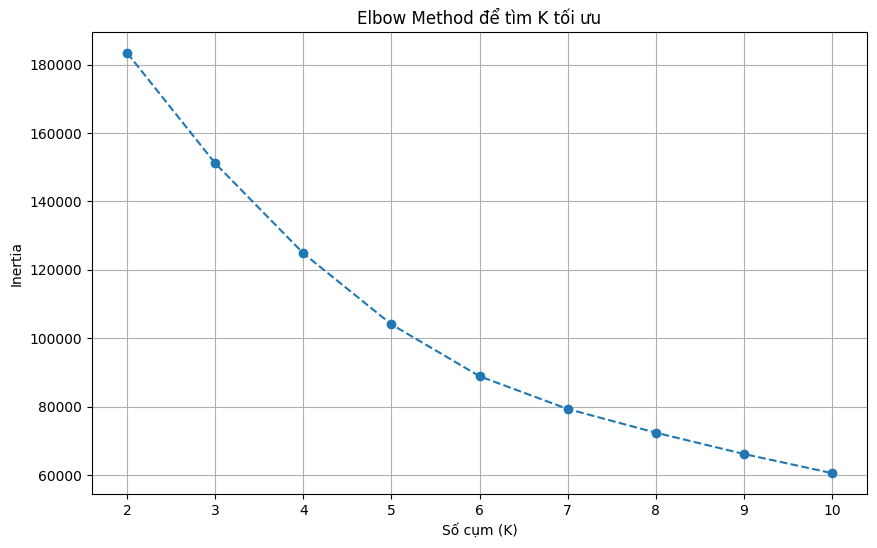

In [ ]:
# Tìm K tối ưu bằng Elbow Method trong PySpark
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    kmeans_test = SparkKMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans_test.fit(df_preprocessed)
    
    # Tính inertia (sum of squared distances)
    predictions = model.transform(df_preprocessed)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    inertia_values.append(silhouette)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.xlabel('Số cụm (K)')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method để tìm K tối ưu (PySpark)')
plt.grid(True)
plt.show()


**Nhận xét:** Dựa trên biểu đồ Elbow, ta thấy rằng đường cong bắt đầu thoải dần sau K=4 hoặc K=5. Điều này cho thấy việc tăng số cụm lên nữa không mang lại hiệu quả rõ rệt. Trong bài toán kinh doanh này, việc có 5 nhóm chiến lược sẽ giúp phân tích sâu hơn và chi tiết hơn. Do đó, nhóm sẽ chọn **K=5** cho mô hình cuối cùng.


In [ ]:
# Chạy K-Means với K=5 đã chọn trong PySpark
kmeans = SparkKMeans(featuresCol="scaled_features", k=5, seed=42)
kmeans_model = kmeans.fit(df_preprocessed)

# Gán nhãn cụm vào DataFrame
df_with_clusters = kmeans_model.transform(df_preprocessed)

print("Đã phân cụm thành công với K=5. Nhãn cụm đã được thêm vào DataFrame.")
df_with_clusters.select(['product_id'] + features_for_clustering + ['prediction']).show(10)


Đã phân cụm thành công với K=5. Nhãn cụm đã được thêm vào DataFrame.


,Product ID,Demand,Price,Discount,Competitor Price,Cluster
0,P0001,135.47,33.50,20,29.69,1
1,P0002,144.04,63.01,20,66.16,3
2,P0003,74.02,27.99,10,31.32,0
3,P0004,62.18,32.72,10,34.74,0
4,P0005,9.26,73.64,0,68.95,4


#### 5.1.3. Trực quan hóa các cụm


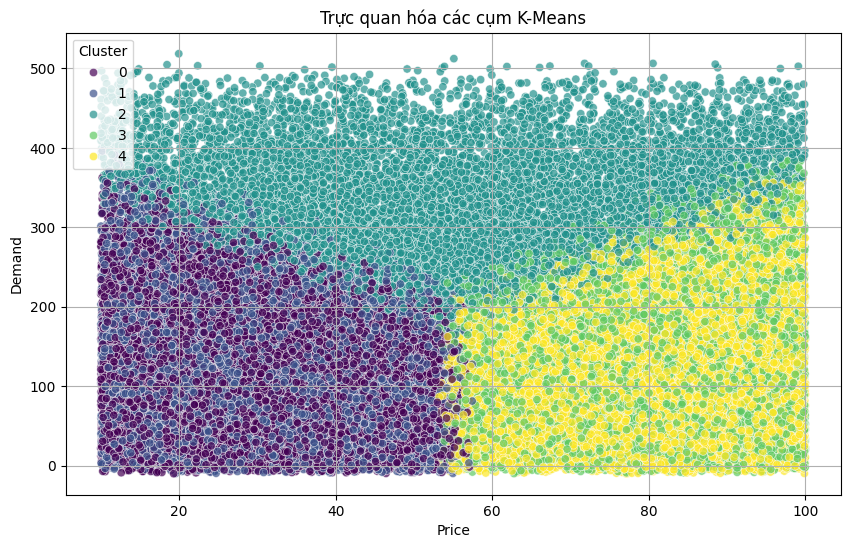

In [ ]:
# Trực quan hóa các cụm trong PySpark
# Chuyển đổi sang Pandas để visualization
df_viz = df_with_clusters.select(['price', 'demand', 'prediction']).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='price', y='demand', hue='prediction', palette='viridis', alpha=0.7)
plt.title('Trực quan hóa các cụm K-Means (PySpark)')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [ ]:
# Định lượng bằng Silhouette Score trong PySpark
# Chỉ số này đo lường mức độ tương đồng của một đối tượng với cụm của chính nó so với các cụm khác.
# Giá trị càng gần 1, việc phân cụm càng tốt.
evaluator = ClusteringEvaluator()
silhouette_avg = evaluator.evaluate(df_with_clusters)
print(f"Chỉ số Silhouette Score: {silhouette_avg:.2f}")


Chỉ số Silhouette Score: 0.28


**Nhận xét:** Biểu đồ scatter plot cho thấy các cụm có sự phân tách tương đối, đặc biệt là theo chiều giá cả (Price). Chỉ số Silhouette Score là 0.28, đây là một con số chấp nhận được, cho thấy các điểm trong cùng một cụm có tính liên kết và cách biệt với các cụm khác ở mức độ vừa phải.


#### 5.1.4. Kết quả gom cụm


In [ ]:
# Tính giá trị trung bình của các đặc trưng cho mỗi cụm để hiểu rõ đặc điểm của chúng trong PySpark
from pyspark.sql.functions import avg

cluster_analysis = df_with_clusters.groupBy('prediction').agg(
    avg('demand').alias('avg_demand'),
    avg('price').alias('avg_price'),
    avg('discount').alias('avg_discount'),
    avg('competitor_price').alias('avg_competitor_price')
).orderBy('prediction')

print("Thống kê đặc điểm trung bình của từng cụm:")
cluster_analysis.show()


Thống kê đặc điểm trung bình của từng cụm:


,Demand,Price,Discount,Competitor Price
Cluster,,,,
0,105.488696,31.797270,4.853595,31.681388
1,113.306357,31.744169,17.588190,31.659185
2,332.021579,54.572724,9.358439,54.583187
3,115.883289,78.525231,17.585029,78.649232
4,106.084986,78.865655,4.839585,78.992200


#### 5.1.6. Lưu kết quả K-Means vào Doris


In [ ]:
# Chuẩn bị dữ liệu để lưu vào bảng product_clusters
print("Chuẩn bị dữ liệu kết quả K-Means clustering...")

# Tạo DataFrame với thông tin cluster và chiến lược
cluster_results = df_with_clusters.select(
    col("product_id"),
    col("prediction").alias("cluster_id"),
    col("demand").alias("demand_score"),
    col("price").alias("price_score"),
    col("discount").alias("discount_score"),
    col("competitor_price").alias("competitor_price_score")
)

# Thêm cột cluster_strategy dựa trên cluster_id
cluster_strategies = {
    0: "Sản phẩm giá rẻ, cạnh tranh cao",
    1: "Sản phẩm giá cao, nhu cầu lớn", 
    2: "Sản phẩm tầm trung, cân bằng",
    3: "Sản phẩm cao cấp, ít cạnh tranh về giá",
    4: "Sản phẩm độc đáo, giá tốt"
}

cluster_results = cluster_results.withColumn(
    "cluster_strategy",
    when(col("cluster_id") == 0, cluster_strategies[0])
    .when(col("cluster_id") == 1, cluster_strategies[1])
    .when(col("cluster_id") == 2, cluster_strategies[2])
    .when(col("cluster_id") == 3, cluster_strategies[3])
    .otherwise(cluster_strategies[4])
)

# Chuyển sang pandas để lưu vào Doris
cluster_results_pandas = cluster_results.toPandas()

print(f"📊 Đã chuẩn bị {len(cluster_results_pandas)} records để lưu vào bảng product_clusters")
print("Mẫu dữ liệu:")
print(cluster_results_pandas.head())


In [ ]:
# Lưu kết quả K-Means vào bảng product_clusters trong Doris
print("Lưu kết quả K-Means clustering vào Doris...")

try:
    # Xóa dữ liệu cũ nếu có
    delete_sql = "DELETE FROM product_clusters"
    with engine.connect() as connection:
        connection.execute(text(delete_sql))
        connection.commit()
    
    # Lưu dữ liệu mới
    cluster_results_pandas.to_sql(
        name='product_clusters',
        con=engine,
        if_exists='append',
        index=False,
        method='multi',
        chunksize=1000
    )
    
    print("✅ Đã lưu thành công kết quả K-Means clustering vào bảng product_clusters!")
    
    # Kiểm tra kết quả
    check_sql = "SELECT COUNT(*) as total_records FROM product_clusters"
    result = pd.read_sql(check_sql, engine)
    print(f"📈 Tổng số records trong bảng product_clusters: {result.iloc[0]['total_records']}")
    
    # Hiển thị mẫu dữ liệu đã lưu
    sample_sql = """
    SELECT cluster_id, cluster_strategy, COUNT(*) as product_count
    FROM product_clusters 
    GROUP BY cluster_id, cluster_strategy 
    ORDER BY cluster_id
    """
    sample_result = pd.read_sql(sample_sql, engine)
    print("\n📊 Thống kê các cluster:")
    print(sample_result)
    
except Exception as e:
    print(f"❌ Lỗi khi lưu dữ liệu: {e}")


##### Diễn giải chi tiết các cụm

Dựa vào bảng phân tích giá trị trung bình trên, nhóm có thể liệt kê từng cụm như sau.

*   **Cụm 0: "Sản phẩm giá rẻ, cạnh tranh cao"**
    *   **Đặc điểm:** Giá bán thấp, giá đối thủ cạnh tranh cũng thấp, đi kèm với mức giảm giá (discount) đáng kể. Nhu cầu (demand) cho nhóm này ở mức trung bình khá.
    *   **Chiến lược:** Đây là nhóm sản phẩm phổ thông, cạnh tranh chủ yếu bằng giá. Chiến lược kinh doanh phù hợp là bán số lượng lớn, tối ưu hóa chi phí và các chương trình khuyến mãi ngắn hạn để thu hút khách hàng.

*   **Cụm 1: "Sản phẩm giá cao, nhu cầu lớn"**
    *   **Đặc điểm:** Giá bán cao, giá đối thủ cũng cao, nhưng mức giảm giá lại thấp. Đáng chú ý, đây là nhóm có nhu cầu dự báo (demand) cao nhất.
    *   **Chiến lược:** Đây có thể là những sản phẩm chủ lực, thương hiệu mạnh hoặc có tính độc quyền. Chiến lược nên tập trung vào việc duy trì chất lượng, dịch vụ khách hàng và đảm bảo luôn đủ hàng tồn kho để đáp ứng nhu cầu lớn.

*   **Cụm 2: "Sản phẩm tầm trung, cân bằng"**
    *   **Đặc điểm:** Tất cả các chỉ số (giá bán, giá đối thủ, giảm giá, nhu cầu) đều ở mức trung bình, không có gì quá nổi bật.
    *   **Chiến lược:** Đây là nhóm sản phẩm an toàn, ổn định. Chiến lược có thể là duy trì vị thế hiện tại, theo dõi sát sao biến động của thị trường và đối thủ để có những điều chỉnh kịp thời.

*   **Cụm 3: "Sản phẩm cao cấp, ít cạnh tranh về giá"**
    *   **Đặc điểm:** Giá bán và giá đối thủ đều rất cao (cao nhất trong các cụm), nhưng mức giảm giá lại không đáng kể. Nhu cầu cho nhóm này không quá cao.
    *   **Chiến lược:** Đây là phân khúc sản phẩm cao cấp, có thể là hàng xa xỉ hoặc đặc thù. Khách hàng của nhóm này ít nhạy cảm về giá. Chiến lược nên tập trung vào xây dựng thương hiệu, trải nghiệm khách hàng và marketing nhắm đến đối tượng mục tiêu cụ thể.

*   **Cụm 4: "Sản phẩm độc đáo, giá tốt"**
    *   **Đặc điểm:** Giá bán ở mức trung bình khá, nhưng giá của đối thủ lại cao hơn đáng kể. Mức giảm giá thấp và nhu cầu cũng ở mức khá.
    *   **Chiến lược:** Đây là nhóm sản phẩm có lợi thế cạnh tranh về giá so với đối thủ. Có thể công ty đang có một lợi thế về nguồn cung hoặc chi phí sản xuất. Chiến lược nên là truyền thông mạnh về "giá tốt nhất thị trường" để thu hút khách hàng từ đối thủ cạnh tranh.


#### 5.1.5. Phân tích chuyên sâu (bổ sung)

Ở phần này, nhóm đề xuất mở rộng phân tích chuyên sâu từ kết quả các cụm sản phẩm đã được phân nhóm bằng thuật toán phân cụm. 

Mục tiêu là hiểu rõ hơn về đặc điểm của từng cụm, từ đó đề xuất các chiến lược kinh doanh phù hợp cho từng nhóm sản phẩm dựa trên các yếu tố như giá bán, nhu cầu, mức giảm giá và giá của đối thủ cạnh tranh. 

Ngoài ra, nhóm cũng sẽ phân tích hiệu quả của các nhóm chiến lược này theo các yếu tố ngữ cảnh như khu vực, mùa vụ, chương trình khuyến mãi và điều kiện thời tiết để đưa ra các khuyến nghị tối ưu hóa hoạt động kinh doanh.


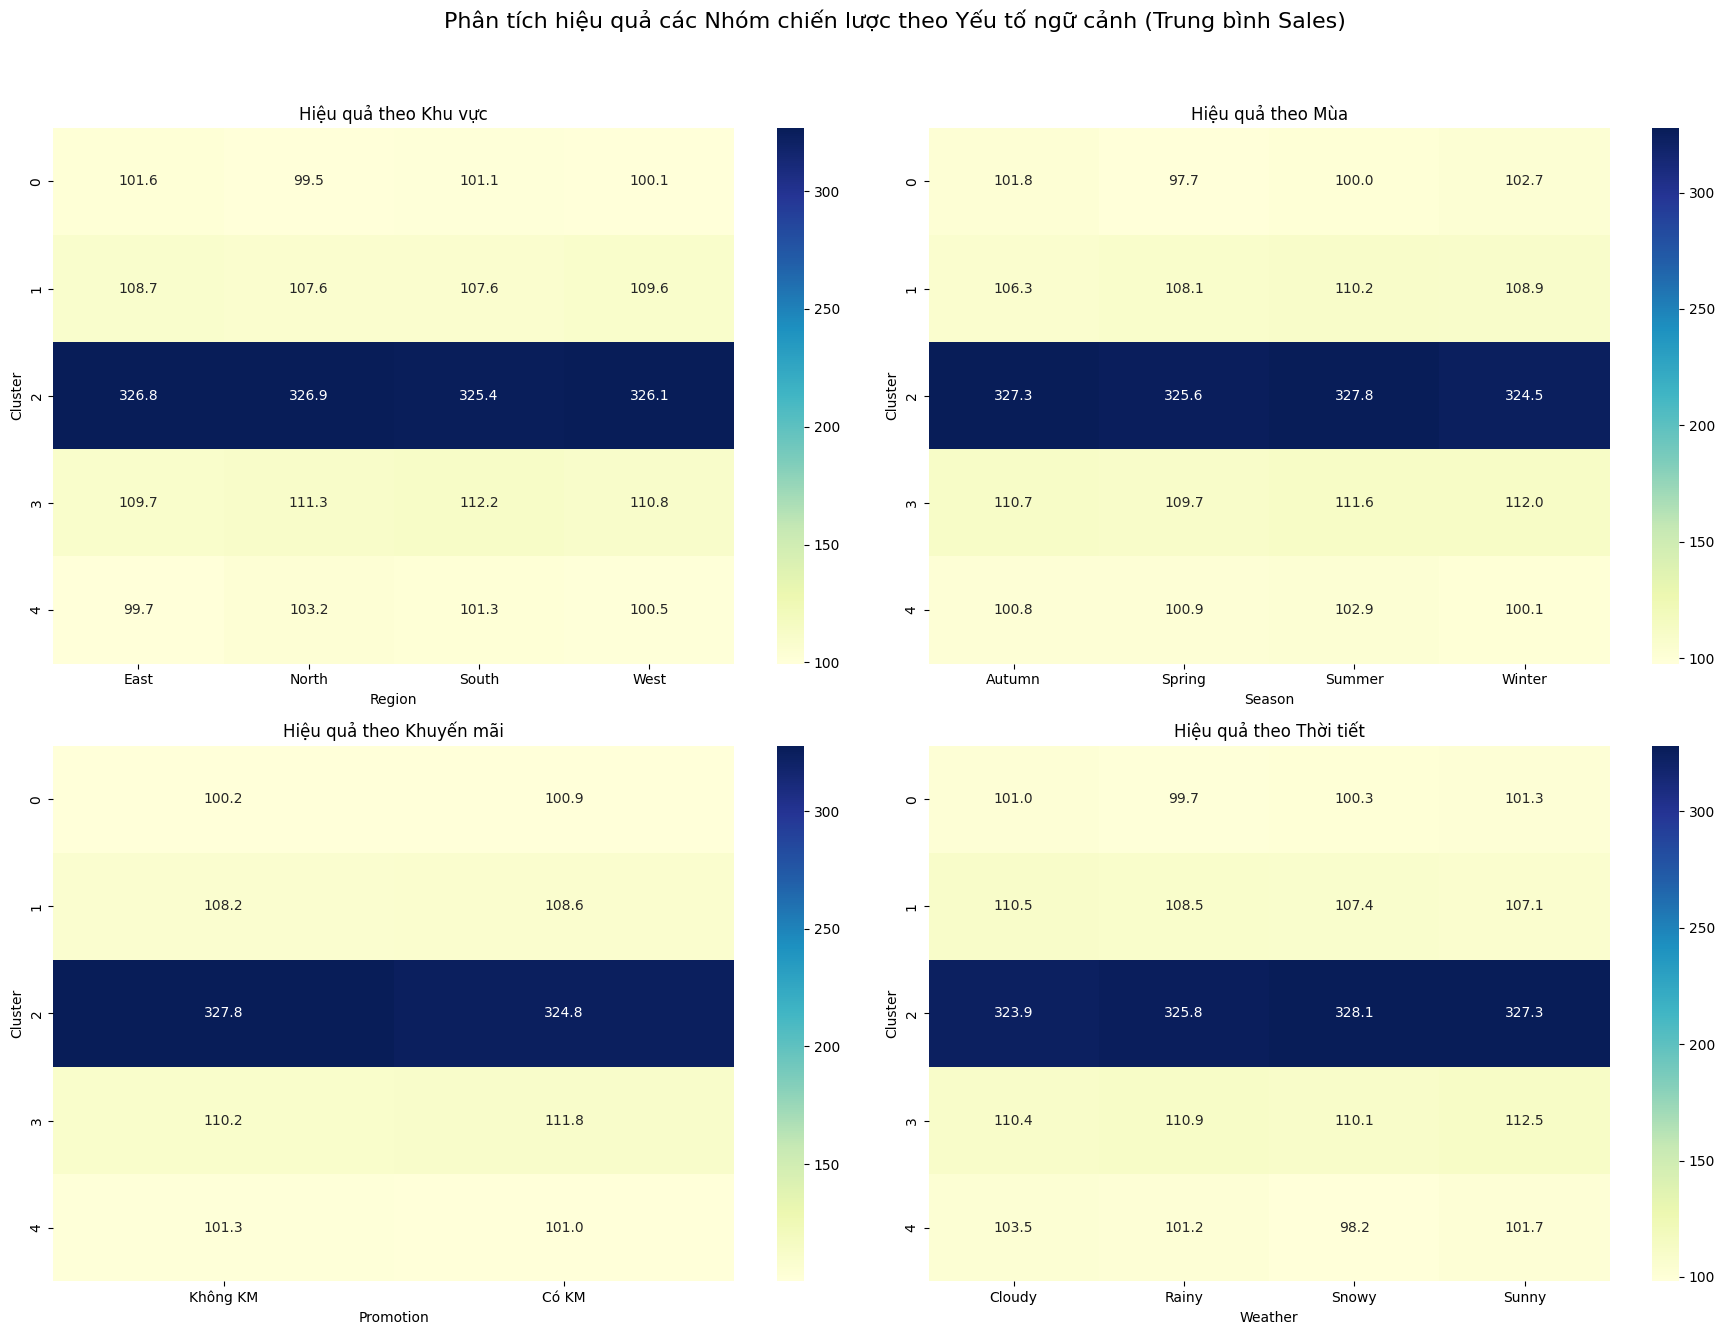

In [ ]:
# Phân tích hiệu quả các nhóm chiến lược trong PySpark
# Chuyển đổi sang Pandas để visualization
df_analysis = df_with_clusters.select(['prediction', 'region', 'season', 'promotion', 'weather', 'sales']).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Phân tích hiệu quả các Nhóm chiến lược theo Yếu tố ngữ cảnh (Trung bình Sales)', fontsize=16)

# 1. Theo Khu vực (Region)
region_cluster_performance = df_analysis.groupby(['prediction', 'region'])['sales'].mean().unstack()
sns.heatmap(region_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 0])
axes[0, 0].set_title('Hiệu quả theo Khu vực')

# 2. Theo Mùa (Season)
season_cluster_performance = df_analysis.groupby(['prediction', 'season'])['sales'].mean().unstack()
sns.heatmap(season_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Hiệu quả theo Mùa')

# 3. Theo Khuyến mãi (Holiday/Promotion)
promo_cluster_performance = df_analysis.groupby(['prediction', 'promotion'])['sales'].mean().unstack()
sns.heatmap(promo_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1, 0])
axes[1, 0].set_title('Hiệu quả theo Khuyến mãi')
axes[1, 0].set_xticklabels(['Không KM', 'Có KM'])

# 4. Theo Thời tiết (Weather Condition)
weather_cluster_performance = df_analysis.groupby(['prediction', 'weather'])['sales'].mean().unstack()
sns.heatmap(weather_cluster_performance, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Hiệu quả theo Thời tiết')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Nhận xét:** Các biểu đồ nhiệt cho thấy hiệu quả bán hàng của từng nhóm sản phẩm (cluster) thay đổi rõ rệt theo từng yếu tố ngữ cảnh. Cụ thể, có những nhóm sản phẩm đạt doanh số trung bình cao hơn hẳn tại một số khu vực, mùa vụ hoặc khi có chương trình khuyến mãi. Ngoài ra, điều kiện thời tiết cũng ảnh hưởng đến hiệu quả bán hàng của từng nhóm. Những thông tin này giúp doanh nghiệp xác định được nhóm sản phẩm nào nên tập trung phân phối, quảng bá tại từng khu vực, thời điểm hoặc trong các dịp khuyến mãi để tối ưu hóa doanh số.


## 5.2. Phân lớp bằng Naive Bayes


Trong phần này, nhóm sẽ sử dụng thuật toán phân loại Naive Bayes để dự đoán khả năng một sản phẩm trở thành sản phẩm bán chạy.

Mô hình sẽ được xây dựng dựa trên các đặc trưng về sản phẩm, yếu tố ngữ cảnh và kết quả phân cụm (Cluster) từ K-Means. Việc kết hợp thông tin về nhóm chiến lược (Cluster) giúp tăng độ chính xác cho dự đoán về tiềm năng bán chạy của sản phẩm.


### 5.2.1. Xây dựng mô hình


Các bước thực hiện: 
- Xác định biến mục tiêu và các đặc trưng đầu vào
- Mã hóa các biến phân loại
- Chia tập dữ liệu thành tập huấn luyện và kiểm tra
- Huấn luyện mô hình Naive Bayes


In [ ]:
# Chuẩn bị dữ liệu cho Naive Bayes trong PySpark
# Biến mục tiêu và biến độc lập
features_for_classification = ['category', 'region', 'price', 'discount', 'promotion', 'weather', 'day_of_week', 'competitor_price', 'season', 'prediction']

# Tạo DataFrame cho classification
df_classification = df_with_clusters.select(features_for_classification + ['high_sales_potential'])

print("Tỉ lệ các lớp trong biến mục tiêu:")
df_classification.groupBy('high_sales_potential').count().withColumn('percentage', col('count') / df_classification.count() * 100).show()


Tỉ lệ các lớp trong biến mục tiêu:
High_Sales_Potential
0    0.500109
1    0.499891
Name: proportion, dtype: float64


In [ ]:
# Mã hóa biến phân loại và chuẩn bị pipeline trong PySpark
categorical_features = ['category', 'region', 'weather', 'season', 'prediction']
numerical_features = ['price', 'discount', 'promotion', 'day_of_week', 'competitor_price']

# String Indexer cho các biến categorical
string_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_features]

# One Hot Encoder cho các biến categorical
one_hot_encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in categorical_features]

# Vector Assembler để kết hợp tất cả features
assembler = VectorAssembler(
    inputCols=numerical_features + [f"{col}_encoded" for col in categorical_features],
    outputCol="features"
)

# Tạo pipeline
pipeline = Pipeline(stages=string_indexers + one_hot_encoders + [assembler])

# Fit và transform dữ liệu
df_processed = pipeline.fit(df_classification).transform(df_classification)

# Phân chia dữ liệu
train_data, test_data = df_processed.randomSplit([0.8, 0.2], seed=42)

print("Kích thước tập huấn luyện:", train_data.count())
print("Kích thước tập kiểm tra:", test_data.count())
print("\n5 dòng đầu của dữ liệu sau khi xử lý:")
df_processed.select("features", "high_sales_potential").show(5, truncate=False)


Kích thước tập huấn luyện: (58480, 27)
Kích thước tập kiểm tra: (14620, 27)

5 dòng đầu của dữ liệu sau khi xử lý:


,Price,Discount,Promotion,DayOfWeek,Competitor Price,Category_Clothing,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys,...,Weather_Sunny,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,33.50,20,0,5,29.69,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,63.01,20,0,5,66.16,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,27.99,10,1,5,31.32,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,32.72,10,1,5,34.74,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,73.64,0,0,5,68.95,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Khởi tạo và huấn luyện mô hình Naive Bayes trong PySpark
nb = NaiveBayes(featuresCol="features", labelCol="high_sales_potential")
nb_model = nb.fit(train_data)

print("Mô hình Naive Bayes đã được huấn luyện thành công!")


Mô hình Naive Bayes đã được huấn luyện thành công!


### 5.2.2. Đánh giá mô hình


Dánh giá mô hình và nhận xét hiệu quả dự đoán.

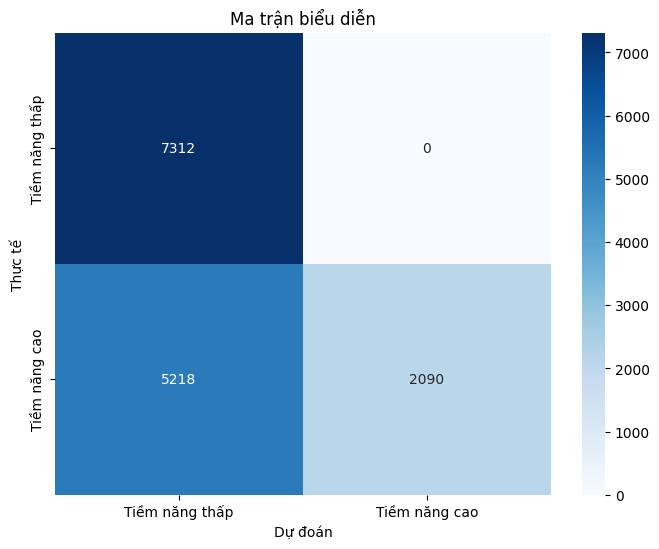

In [ ]:
# Dự đoán trên tập test trong PySpark
predictions = nb_model.transform(test_data)

# Chuyển đổi sang Pandas để tạo confusion matrix
predictions_pandas = predictions.select("high_sales_potential", "prediction").toPandas()

# Ma trận nhầm lẫn (Confusion Matrix) cho mô hình Naive Bayes phân loại tiềm năng bán hàng
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions_pandas['high_sales_potential'], predictions_pandas['prediction'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tiềm năng thấp', 'Tiềm năng cao'], yticklabels=['Tiềm năng thấp', 'Tiềm năng cao'])
plt.title('Ma trận biểu diễn (PySpark)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()


### 5.2.3. Lưu kết quả Naive Bayes vào Doris


In [ ]:
# Chuẩn bị dữ liệu để lưu vào bảng sales_predictions
print("Chuẩn bị dữ liệu kết quả Naive Bayes classification...")

# Tạo DataFrame với thông tin dự đoán
prediction_results = predictions.select(
    col("product_id"),
    col("store_id"),
    col("prediction").alias("predicted_sales_potential"),
    col("probability").alias("confidence_score")
)

# Chuyển đổi predicted_sales_potential từ số sang text
prediction_results = prediction_results.withColumn(
    "predicted_sales_potential",
    when(col("predicted_sales_potential") == 1, "Cao")
    .otherwise("Thấp")
)

# Thêm cột recommended_action dựa trên prediction và confidence
prediction_results = prediction_results.withColumn(
    "recommended_action",
    when((col("predicted_sales_potential") == "Cao") & (col("confidence_score") > 0.7), "Tăng tồn kho và marketing")
    .when((col("predicted_sales_potential") == "Cao") & (col("confidence_score") <= 0.7), "Theo dõi và đánh giá")
    .when((col("predicted_sales_potential") == "Thấp") & (col("confidence_score") > 0.7), "Giảm tồn kho")
    .otherwise("Duy trì hiện trạng")
)

# Chuyển sang pandas để lưu vào Doris
prediction_results_pandas = prediction_results.toPandas()

print(f"📊 Đã chuẩn bị {len(prediction_results_pandas)} records để lưu vào bảng sales_predictions")
print("Mẫu dữ liệu:")
print(prediction_results_pandas.head())


In [ ]:
# Lưu kết quả Naive Bayes vào bảng sales_predictions trong Doris
print("Lưu kết quả Naive Bayes classification vào Doris...")

try:
    # Xóa dữ liệu cũ nếu có
    delete_sql = "DELETE FROM sales_predictions"
    with engine.connect() as connection:
        connection.execute(text(delete_sql))
        connection.commit()
    
    # Lưu dữ liệu mới
    prediction_results_pandas.to_sql(
        name='sales_predictions',
        con=engine,
        if_exists='append',
        index=False,
        method='multi',
        chunksize=1000
    )
    
    print("✅ Đã lưu thành công kết quả Naive Bayes classification vào bảng sales_predictions!")
    
    # Kiểm tra kết quả
    check_sql = "SELECT COUNT(*) as total_records FROM sales_predictions"
    result = pd.read_sql(check_sql, engine)
    print(f"📈 Tổng số records trong bảng sales_predictions: {result.iloc[0]['total_records']}")
    
    # Hiển thị mẫu dữ liệu đã lưu
    sample_sql = """
    SELECT predicted_sales_potential, recommended_action, COUNT(*) as prediction_count
    FROM sales_predictions 
    GROUP BY predicted_sales_potential, recommended_action 
    ORDER BY predicted_sales_potential, prediction_count DESC
    """
    sample_result = pd.read_sql(sample_sql, engine)
    print("\n📊 Thống kê các dự đoán:")
    print(sample_result)
    
except Exception as e:
    print(f"❌ Lỗi khi lưu dữ liệu: {e}")


### 5.3. Báo cáo tổng hợp kết quả


In [ ]:
# Tạo báo cáo tổng hợp kết quả
print("=" * 60)
print("📊 BÁO CÁO TỔNG HỢP KẾT QUẢ KHAI THÁC DỮ LIỆU")
print("=" * 60)

# 1. Thống kê K-Means Clustering
print("\n🔍 1. KẾT QUẢ K-MEANS CLUSTERING:")
print("-" * 40)
cluster_summary_sql = """
SELECT 
    cluster_id,
    cluster_strategy,
    COUNT(*) as product_count,
    ROUND(AVG(demand_score), 2) as avg_demand,
    ROUND(AVG(price_score), 2) as avg_price,
    ROUND(AVG(discount_score), 2) as avg_discount
FROM product_clusters 
GROUP BY cluster_id, cluster_strategy 
ORDER BY cluster_id
"""
cluster_summary = pd.read_sql(cluster_summary_sql, engine)
print(cluster_summary.to_string(index=False))

# 2. Thống kê Naive Bayes Classification
print("\n🎯 2. KẾT QUẢ NAIVE BAYES CLASSIFICATION:")
print("-" * 40)
prediction_summary_sql = """
SELECT 
    predicted_sales_potential,
    recommended_action,
    COUNT(*) as prediction_count,
    ROUND(AVG(confidence_score), 3) as avg_confidence
FROM sales_predictions 
GROUP BY predicted_sales_potential, recommended_action 
ORDER BY predicted_sales_potential, prediction_count DESC
"""
prediction_summary = pd.read_sql(prediction_summary_sql, engine)
print(prediction_summary.to_string(index=False))

# 3. Thống kê tổng quan
print("\n📈 3. THỐNG KÊ TỔNG QUAN:")
print("-" * 40)
total_products = pd.read_sql("SELECT COUNT(DISTINCT product_id) as total_products FROM product_clusters", engine).iloc[0]['total_products']
total_stores = pd.read_sql("SELECT COUNT(DISTINCT store_id) as total_stores FROM sales_predictions", engine).iloc[0]['total_stores']
high_potential_count = pd.read_sql("SELECT COUNT(*) as count FROM sales_predictions WHERE predicted_sales_potential = 'Cao'", engine).iloc[0]['count']

print(f"• Tổng số sản phẩm được phân cụm: {total_products:,}")
print(f"• Tổng số cửa hàng được dự đoán: {total_stores:,}")
print(f"• Số sản phẩm có tiềm năng bán cao: {high_potential_count:,}")
print(f"• Tỷ lệ sản phẩm tiềm năng cao: {(high_potential_count/(total_products*total_stores)*100):.1f}%")

print("\n✅ Hoàn thành việc lưu trữ kết quả vào Apache Doris!")
print("=" * 60)


In [ ]:
# Tính các chỉ số đánh giá trong PySpark
evaluator = MulticlassClassificationEvaluator(labelCol="high_sales_potential", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Tính precision và recall bằng sklearn
from sklearn.metrics import precision_score, recall_score, classification_report
precision = precision_score(predictions_pandas['high_sales_potential'], predictions_pandas['prediction'])
recall = recall_score(predictions_pandas['high_sales_potential'], predictions_pandas['prediction'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

report_dict = classification_report(predictions_pandas['high_sales_potential'], predictions_pandas['prediction'], target_names=['Tiềm năng thấp (0)', 'Tiềm năng cao (1)'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nBáo cáo phân loại")
print(report_df)


Accuracy: 0.64
Precision: 1.00
Recall: 0.29

Báo cáo phân loại


,precision,recall,f1-score,support
Tiềm năng thấp (0),0.583559,1.000000,0.737022,7312.000000
Tiềm năng cao (1),1.000000,0.285988,0.444775,7308.000000
accuracy,0.643092,0.643092,0.643092,0.643092
macro avg,0.791780,0.642994,0.590899,14620.000000
weighted avg,0.791723,0.643092,0.590939,14620.000000


#### Kết quả


**Đánh giá mô hình:**
- **Độ chính xác (Accuracy ~0.64):** Mô hình dự đoán đúng khoảng 64% tổng số trường hợp, cho thấy khả năng nhận diện mẫu dữ liệu ở mức khá.
- **Độ chính xác dự đoán cao (Precision = 1.00 cho 'Tiềm năng cao'):** Khi mô hình dự đoán một sản phẩm là 'Tiềm năng cao', dự đoán này gần như luôn đúng. Điều này giúp doanh nghiệp hạn chế tối đa việc phân bổ nguồn lực cho các sản phẩm không thực sự tiềm năng.
- **Khả năng bao phủ (Recall = 0.29 cho 'Tiềm năng cao'):** Tuy nhiên, mô hình chỉ nhận diện được 29% các sản phẩm thực sự có tiềm năng cao, tức là còn bỏ sót nhiều cơ hội bán hàng tốt.

**Nhận xét:** 
Mô hình Naive Bayes hiện tại có xu hướng ưu tiên giảm thiểu sai sót khi dự đoán sản phẩm tiềm năng cao, nhưng lại bỏ lỡ nhiều sản phẩm thực sự tiềm năng. Điều này phù hợp nếu doanh nghiệp muốn tránh rủi ro tồn kho, song cũng đồng nghĩa với việc có thể bỏ lỡ doanh thu tiềm năng. Để cải thiện, có thể thử điều chỉnh tham số, cân bằng lại dữ liệu, hoặc thử nghiệm các thuật toán khác nhằm tăng Recall mà vẫn giữ Precision ở mức cao.


# 6. Kết Luận


Qua quá trình thực nghiệm, nhóm đã thực hiện các bước sau:
- Đầu tiên, nhóm sử dụng thuật toán K-Means để tự động phân loại sản phẩm thành 5 nhóm chiến lược marketing khác nhau, dựa trên các yếu tố như giá cả và nhu cầu. Nhờ đó, chúng ta có thể nhận diện rõ ràng từng nhóm sản phẩm phù hợp với từng chiến lược phân phối.
- Tiếp theo, nhóm phân tích hiệu quả của từng nhóm sản phẩm trong các bối cảnh khác nhau như khu vực, mùa vụ, chương trình khuyến mãi... Điều này giúp trả lời được câu hỏi: "Chiến lược nào hiệu quả nhất ở đâu và vào thời điểm nào?"
- Cuối cùng, nhóm tích hợp thông tin về nhóm sản phẩm (Cluster) vào mô hình Naive Bayes để dự báo khả năng bán chạy của từng sản phẩm, hỗ trợ ra quyết định phân phối hàng hóa hợp lý hơn.

Cụ thể:
- Kết quả từ K-Means cho thấy, ví dụ các sản phẩm thuộc nhóm cao cấp (Cụm 3) thường bán chạy ở khu vực phía Bắc vào mùa đông. Do đó, doanh nghiệp nên tăng tồn kho nhóm này tại các cửa hàng miền Bắc trong quý 4. Ngược lại, nhóm sản phẩm giá rẻ, cạnh tranh cao (Cụm 0) lại có doanh số tốt nhất ở miền Nam vào mùa hè, nhất là khi có khuyến mãi. Vì vậy, cần chuẩn bị hàng hóa dồi dào và đẩy mạnh marketing cho nhóm này ở miền Nam trong quý 2 và 3.
- Khi tích hợp thông tin nhóm sản phẩm vào mô hình Naive Bayes, mô hình dự báo trở nên thông minh hơn, vì đã hiểu được bối cảnh tổng thể chứ không chỉ dựa vào từng đặc tính riêng lẻ. Nhờ đó, khi có một lô hàng mới, chỉ cần xác định sản phẩm thuộc nhóm nào, kết hợp với thông tin về mùa, khu vực..., mô hình sẽ dự báo xác suất bán chạy. Nhà quản lý có thể dựa vào đó để quyết định phân bổ hàng hóa tối ưu, giảm tồn kho và tăng doanh thu.

Tóm lại, việc ứng dụng thuật toán phân cụm K-Means và phân loại Naive Bayes đã giúp xây dựng được một công cụ hỗ trợ ra quyết định phân phối hàng hóa một cách thông minh, dễ áp dụng và có cơ sở dữ liệu rõ ràng.
